In [1]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 5.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

In [3]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)
aus_retail.head()

,A3349335T,A3349627V,A3349338X,A3349398A,A3349468W,A3349336V,A3349337W,A3349397X,A3349399C,A3349874C,A3349871W,A3349790V,A3349556W,A3349791W,A3349401C,A3349873A,A3349872X,A3349709X,A3349792X,A3349789K,A3349555V,A3349565X,A3349414R,A3349799R,A3349642T,A3349413L,A3349564W,A3349416V,A3349643V,A3349483V,A3349722T,A3349727C,A3349641R,A3349639C,A3349415T,A3349349F,A3349563V,A3349350R,A3349640L,A3349566A,...,A3349605F,A3349688X,A3349456L,A3349774V,A3349848X,A3349457R,A3349851L,A3349604C,A3349608L,A3349609R,A3349773T,A3349852R,A3349775W,A3349776X,A3349607K,A3349849A,A3349850K,A3349606J,A3349932R,A3349862V,A3349462J,A3349463K,A3349334R,A3349863W,A3349781T,A3349861T,A3349626T,A3349617R,A3349546T,A3349787F,A3349333L,A3349860R,A3349464L,A3349389X,A3349461F,A3349788J,A3349547V,A3349388W,A3349870V,A3349396W
Series ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-04-01,303.1,41.7,63.9,408.7,65.8,91.8,53.6,211.3,94.0,32.7,126.7,178.3,50.4,22.2,43.0,62.4,178.0,61.8,85.4,147.2,1250.2,257.9,17.3,34.9,310.2,58.2,55.8,59.1,173.1,93.6,26.3,119.9,104.2,42.2,15.6,31.6,34.4,123.7,36.4,48.7,...,1.6,15.5,2.7,4.4,2.6,9.7,3.7,2.2,5.9,10.3,2.3,1.1,2.5,2.2,8.1,4.4,3.2,7.6,57.1,933.4,79.6,149.6,1162.6,200.3,243.4,148.6,592.3,268.5,91.4,359.9,460.1,135.1,64.9,125.6,153.5,479.1,146.3,196.1,342.4,3396.4
1982-05-01,297.8,43.1,64.0,404.9,65.8,102.6,55.4,223.8,105.7,35.6,141.3,202.8,49.9,23.1,45.3,63.1,181.5,60.8,84.8,145.6,1300.0,257.4,18.1,34.6,310.1,62.0,58.4,59.2,179.5,95.3,27.1,122.5,110.2,42.1,15.8,31.5,34.4,123.9,36.2,48.9,...,1.6,15.1,3.0,4.9,3.3,11.1,3.8,2.1,5.9,10.6,2.5,1.0,2.5,2.0,8.0,3.4,3.3,6.7,57.3,920.5,80.8,149.7,1150.9,210.3,268.3,151.0,629.6,289.8,96.8,386.6,502.6,134.9,67.7,128.7,154.8,486.1,145.5,196.6,342.1,3497.9
1982-06-01,298.0,40.3,62.7,401.0,62.3,105.0,48.4,215.7,95.1,32.5,127.6,176.3,48.0,22.8,43.7,59.6,174.1,58.7,80.7,139.4,1234.2,261.2,18.1,34.6,313.9,53.8,53.7,59.8,167.3,85.2,24.3,109.6,96.7,38.5,15.2,29.6,33.5,116.8,35.7,47.1,...,1.7,15.5,2.5,4.8,2.7,9.9,3.2,2.0,5.1,9.9,2.3,1.0,2.5,2.0,7.8,3.6,3.5,7.1,55.3,933.6,77.3,149.0,1160.0,198.7,266.1,142.6,607.4,261.9,88.6,350.5,443.8,128.2,65.5,125.0,148.8,467.5,140.2,188.5,328.7,3357.8
1982-07-01,307.9,40.9,65.6,414.4,68.2,106.0,52.1,226.3,95.3,33.5,128.8,172.6,48.6,23.2,46.5,61.9,180.2,60.3,82.4,142.7,1265.0,266.1,18.9,35.2,320.2,57.9,56.9,59.8,174.5,91.6,25.6,117.2,104.6,38.9,15.2,35.2,33.4,122.7,34.6,47.5,...,1.6,16.1,2.8,5.1,2.4,10.2,3.4,2.1,5.4,8.8,2.6,1.1,2.6,2.0,8.3,4.0,3.5,7.5,56.3,972.6,80.4,153.5,1206.4,208.7,273.5,150.1,632.4,267.2,92.1,359.3,459.1,129.9,68.5,136.6,156.1,491.1,146.5,192.0,338.5,3486.8
1982-08-01,299.2,42.1,62.6,403.8,66.0,96.9,54.2,217.1,82.8,29.4,112.3,169.6,51.3,21.4,44.8,60.7,178.1,56.1,80.7,136.8,1217.6,247.2,19.0,33.8,300.1,59.2,56.7,62.2,178.1,85.2,23.5,108.7,92.5,39.5,14.5,34.7,33.2,122.0,32.5,49.3,...,1.6,15.8,2.8,4.6,2.7,10.1,3.1,2.0,5.0,8.8,2.6,0.9,2.8,2.0,8.4,3.6,3.7,7.3,55.4,923.5,81.6,147.3,1152.5,206.2,262.7,153.7,622.6,241.5,83.7,325.2,438.4,133.0,65.2,134.7,152.8,485.7,138.8,192.7,331.5,3355.9


In [4]:
train_bound = pd.Timestamp('2016-02-01')
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

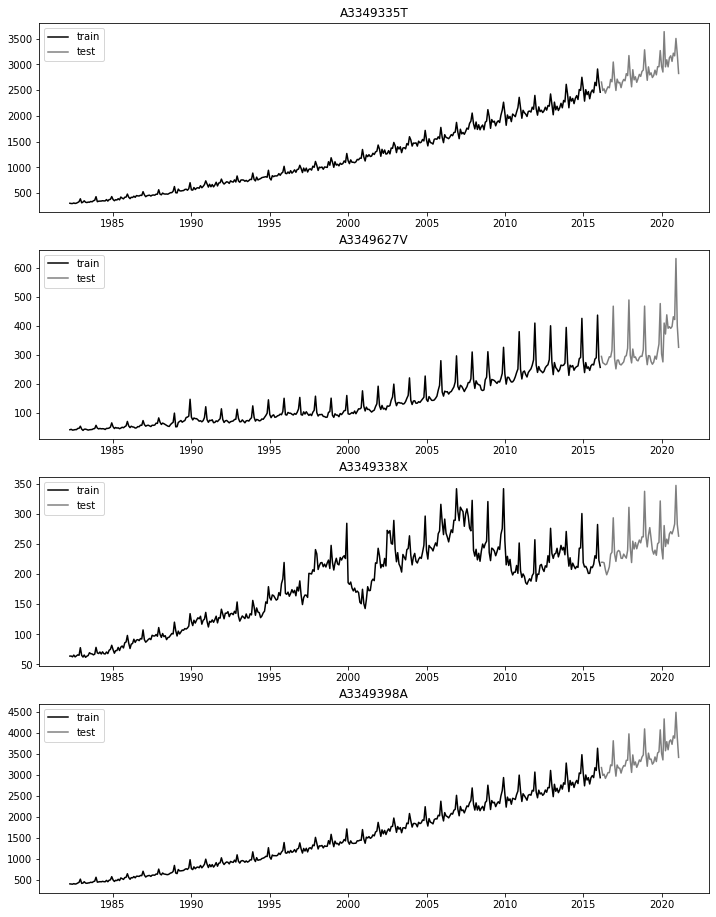

In [5]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.legend()
    plt.title(col)

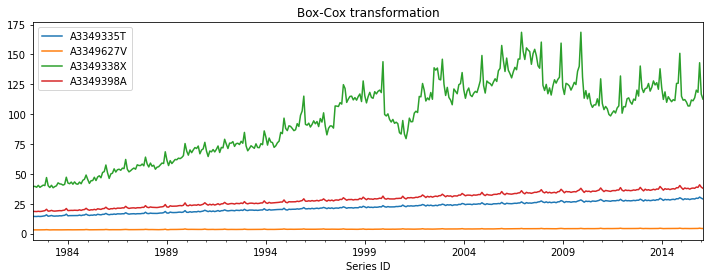

In [6]:
boxcox_model = BoxCox()
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [7]:
lambds

{'A3349335T': 0.2849374963384148,
 'A3349338X': 0.85262045917212,
 'A3349398A': 0.3239342116951898,
 'A3349627V': -0.10305050735646222}

In [8]:
for col in train.columns:
    kpss_stat, p_value, lags, crit = kpss(bc_train[col], nlags='auto')
    print(col, 'Stationary' if p_value > 0.05 else 'Non-stationary')

A3349335T Non-stationary
A3349627V Non-stationary
A3349338X Non-stationary
A3349398A Non-stationary


In [9]:
def differencing(ts, periods):
    return ts.diff(periods=periods).dropna()

def integration(ts, periods, original_ts):
    ts_concat = pd.concat([original_ts.iloc[:periods], ts])
    ts_integration = []
    for i in range(periods):
        ts_integration.append(ts_concat.iloc[i::periods].cumsum(axis=0))
    return pd.concat(ts_integration).sort_index()

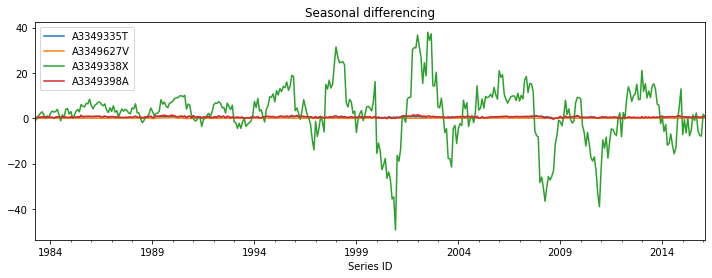

In [10]:
seasonal_lag = 12
t_train = differencing(bc_train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

In [11]:
for col in train.columns:
    kpss_stat, p_value, lags, crit = kpss(t_train[col], nlags='auto')
    print(col, 'Stationary' if p_value > 0.05 else 'Non-stationary')

A3349335T Stationary
A3349627V Stationary
A3349338X Stationary
A3349398A Stationary


In [12]:
import requests
url = 'https://raw.githubusercontent.com/locuslab/TCN/master/TCN/tcn.py'
open('tcn.py', 'wb').write(requests.get(url).content);

In [13]:
from tcn import TemporalConvNet
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.optim import Adam

from IPython.display import clear_output

In [14]:
class DeepTCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = TemporalConvNet(
            num_inputs=4, num_channels=[4, 4, 4, 4], 
            kernel_size=2, dropout=0.2)
        self.mu = nn.Linear(in_features=60, out_features=60)
        self.sigma = nn.Linear(in_features=60, out_features=60)
    
    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        sigma = F.softplus(self.sigma(h))
        return mu, sigma

In [15]:
def gaussian_loss(mu, sigma, y, softZero=1e-4):
    logGaussian = -torch.log(2*np.pi*(sigma**2)+softZero)/2-(y-mu)**2/(2*(sigma**2)+softZero)
    res = -logGaussian.sum(dim=0)
    return res.mean()

In [16]:
train_torch = []
for i in range(t_train.shape[0] - 120):
    train_torch.append(t_train.iloc[i:i+120].values.T)
train_torch = torch.Tensor(train_torch).to('cuda')
train_torch.shape

torch.Size([275, 4, 120])

In [18]:
model = DeepTCN()
model.to('cuda');

In [19]:
logs = []

In [25]:
opt = Adam(model.parameters(), lr=0.00005)

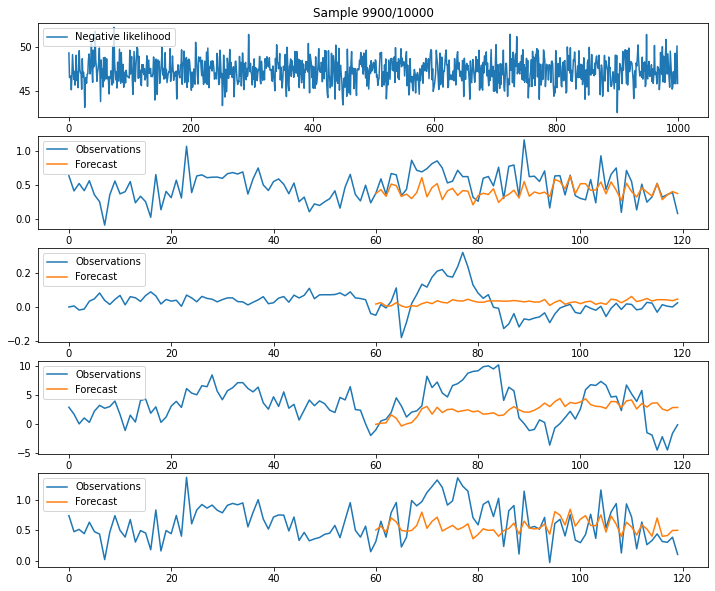

In [26]:
n_epochs = 10000
batch_size = 100
for e in range(n_epochs):
    idx = np.random.choice(np.arange(train_torch.shape[0]), size=batch_size)
    train_batch = train_torch[idx]

    x, y = train_batch[..., :60], train_batch[..., 60:]

    mu, sigma = model(x)
    train_loss = gaussian_loss(mu, sigma, y)

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    logs.append(train_loss.item())
    if e % 100 == 0:
        plt.figure(figsize=(12, 2*5))
        plt.subplot(5, 1, 1)
        plt.plot(logs[-1000:], label='Negative likelihood')
        plt.legend(loc='upper left')
        plt.title('Sample {}/{}'.format(e, n_epochs))
        obs = train_batch[0].cpu().numpy()
        forecast = mu[0].detach().cpu().numpy()
        for i in range(4):
            plt.subplot(5, 1, i+2)
            plt.plot(np.arange(120), obs[i], label='Observations')
            plt.plot(np.arange(60, 120), forecast[i], label='Forecast')
            plt.legend(loc='upper left')
        plt.show()
        clear_output(wait=True)

In [27]:
print('Train loss: {:.2f}'.format(logs[-1]))

Train loss: 49.40


In [28]:
#torch.save(model, 'gaussian_tcn_shallow_glance.model')
#model = torch.load('gaussian_tcn_shallow_glance.model')

In [29]:
with torch.no_grad():
    mu, sigma = model(train_torch[-1:, :, 60:])
point_forecast = mu[0].cpu().numpy().T
lower_forecast = (mu[0] - sigma[0] * 2.807034).cpu().numpy().T
upper_forecast = (mu[0] + sigma[0] * 2.807034).cpu().numpy().T

In [30]:
point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

In [31]:
pred = point_forecast.copy()
lower = lower_forecast.copy()
upper = upper_forecast.copy()

In [32]:
bc_pred = integration(point_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_lower = integration(lower_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_upper = integration(upper_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_pred.shape

(60, 4)

In [33]:
bc_lower[bc_lower < 0] = 0

In [34]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = inv_boxcox(bc_pred[col].values, lambds[col])
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])
pred.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,2632.590031,277.932492,219.947376,3153.190666
2016-04-01,2531.620723,257.235689,218.155055,3011.222117
2016-05-01,2587.203844,267.899206,206.095326,3093.925370
2016-06-01,2417.695895,252.357940,206.817620,2900.673247
2016-07-01,2602.675280,275.841098,219.499976,3115.586778


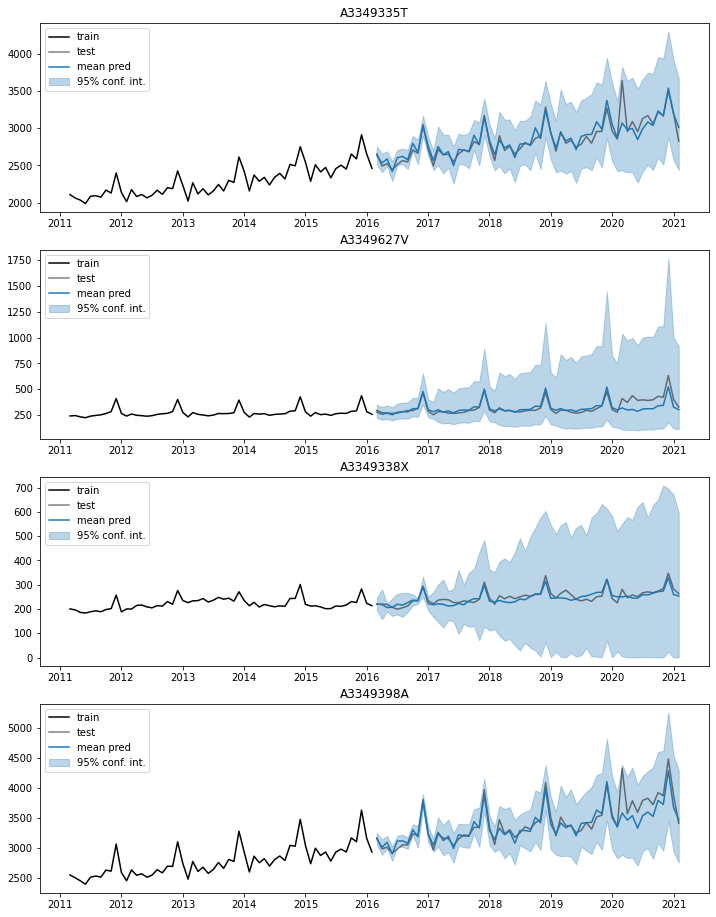

In [35]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)